In [1]:
import pypsa
import pandas as pd
import numpy as np

In [2]:
solver = "highs"

*** 
Check-point 1:

**Build a network in PyPSA with two nodes (`bus`) and following components to build a simple green hydrogen production system:**

1. An `Electricity` bus with electricity as `carrier`.
   1. A wind generator connected to this bus.
   2. A load_shedding generator connected to this bus.
2. A `Hydrogen` bus with hydrogen as `carrier`.
   1. A hydrogen demand load connected to this bus.
3. An electrolyser link to convert electricity into hydrogen.

**For simplicity, we assume the hydrogen demand profile to be flat for now. Afterwards, we want to supply electricy by attaching one renewable power plant implemented as (`generator`) (you have to call [`network.set_snapshots`](https://pypsa.readthedocs.io/en/latest/api/_source/pypsa.Network.set_snapshots.html) to select a year). As help you should have a look at the [PyPSA documentation](https://pypsa.readthedocs.io/en/latest/) and the [Minimal LOPF example](https://pypsa.readthedocs.io/en/latest/examples/minimal_example_pf.html), understand what the [components documentation](https://pypsa.readthedocs.io/en/latest/user-guide/components.html) of PyPSA gives you and that you can find the underlying objective function and constraints in the [LOPF documentation](https://pypsa.readthedocs.io/en/stable/user-guide/optimal-power-flow.html).**


> **Remarks:** For time reasons, you do not have to build the network from scratch. However, to get you acquainted with PyPSA we have omitted a few elements or some of the parameters of the network marked by three question marks `???`. Either, you have to add an element similar to the one in the box above or add a few parameters.

<img src="../../data/block diagrams/d2_e1-1.svg" width=350/>

#### Initialize network

In [3]:
# Create empty PyPSA network
network = pypsa.Network(name="d2_h2_system_example_1")

In [4]:
# Set snapshots to the year 2023 and at hourly resolution
snapshots = pd.date_range("01-01-2023", "01-01-2024", freq="h", inclusive="left")
network.set_snapshots(snapshots)

In [5]:
network.snapshots

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-12-31 14:00:00', '2023-12-31 15:00:00',
               '2023-12-31 16:00:00', '2023-12-31 17:00:00',
               '2023-12-31 18:00:00', '2023-12-31 19:00:00',
               '2023-12-31 20:00:00', '2023-12-31 21:00:00',
               '2023-12-31 22:00:00', '2023-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq='h')

In [6]:
# Import an example of wind daily pattern
wind_pattern = pd.read_csv(
    "../../data/weather data/example_onshore_wind_daily_pattern.csv"
)["daily pattern"]
# annual time-series availability of onshore wind (just a simplified example)
wind_profile = pd.Series(list(wind_pattern) * 365, index=network.snapshots)

<Axes: xlabel='snapshot'>

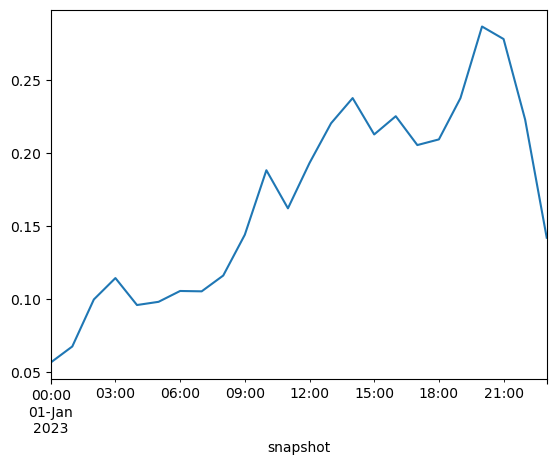

In [7]:
wind_profile.head(24).plot()

Add an `electricity` bus with electricity as `carrier`

In [8]:
network.add(class_name="Bus", name="electricity", carrier="electricity")

Index(['electricity'], dtype='object')

Add a `hydrogen` bus with hydrogen as `carrier`

In [9]:
network.add(class_name="Bus", name="hydrogen", carrier="hydrogen")

Index(['hydrogen'], dtype='object')

In [10]:
network.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
electricity,1.0,,0.0,0.0,electricity,,,1.0,0.0,inf,PQ,,
hydrogen,1.0,,0.0,0.0,hydrogen,,,1.0,0.0,inf,PQ,,


Add constant hourly hydrogen load of `100MW` at the hydrogen bus. The name of the load can be `hydrogen_load`

In [11]:
network.add(class_name="Load", name="hydrogen_load", bus="hydrogen", p_set=100)

Index(['hydrogen_load'], dtype='object')

In [12]:
network.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
hydrogen_load,hydrogen,,,100.0,0.0,-1.0,True


Add a wind generator at the electricity bus with an initial capacity of `100MW`, maximum capacity of `500MW`, and marginal cost of `0$/MWh` into the network. The name of the generator can be `onshore_wind`. 

In [13]:
network.add(
    class_name="Generator",
    name="onshore_wind",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=100,  # MW
    p_nom_max=500,  # MW
    marginal_cost=0,  # $/MWh
    p_max_pu=wind_profile,
)

Index(['onshore_wind'], dtype='object')

Add an electrolyser link, representing the electrolysis conversion with initial capacity of `20MW`, based on provided CAPEX, FOM, VOM, efficiency, interest rate and lifetime.

> **Source:** all costs for the example are taken from [PyPSA technology database](https://github.com/PyPSA/technology-data/blob/master/outputs/costs_2025.csv) and the assumptions in year 2023 in [EU map of hydrogen production costs](https://public.flourish.studio/visualisation/16659363/), with exchange rate of `1.1USD/EUR`

In [14]:
# Electrolyser's techno-economic parameters are given as:
eur_to_usd = 1.1
lifetime = 20
interest = 0.05

CAPEX = 1590 * eur_to_usd  # $/MW
FOM = 32 * eur_to_usd  # $/MW fixed
VOM = 0  # $/MWh variable
efficiency = 0.59

In [15]:
# We need to calculate annualized capital expenditure
def calculate_annualised_capex(capex: float, interest: float, lifetime: int):
    crf = (
        interest * (1 + interest) ** lifetime / ((1 + interest) ** lifetime - 1)
    )  # Capital recovery factor
    return capex * crf

In [16]:
annualized_capex = calculate_annualised_capex(CAPEX, interest, lifetime)

network.add(
    class_name="Link",
    name="electrolyser",
    bus0="electricity",
    bus1="hydrogen",
    p_nom_extendable=True,
    p_nom=20,
    capital_cost=annualized_capex + FOM,  # $/MW
    marginal_cost=VOM,  # $/MWh
    efficiency=efficiency,
    lifetime=lifetime,
)

Index(['electrolyser'], dtype='object')

Now try to solve your network

In [17]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['electrolyser'], dtype='object', name='Link')


Index(['onshore_wind'], dtype='object', name='Generator')
Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 93.76it/s]
INFO:linopy.io: Writing time: 0.69s
Status: warning
Termination condition: infeasible
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: Infeasible



ERROR:   getOptionIndex: Option "pyomo" is unknown
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-p34av2nm has 52563 rows; 17523 cols; 78843 nonzeros
Coefficient ranges:
  Matrix  [6e-02, 1e+00]
  Cost    [1e+00, 2e+02]
  Bound   [4e+03, 4e+03]
  RHS     [1e+02, 5e+02]
Presolving model
Problem status detected on presolve: Infeasible
Model name          : linopy-problem-p34av2nm
Model status        : Infeasible
Objective value     :  0.0000000000e+00
HiGHS run time      :          0.04


('warning', 'infeasible')

Lets look at the optimisation. Does it solve successfully?

Add a load shedding generator at the electricity bus with marginal cost of `9999$/MWh` (or any large figures) into the network. The name of the generator can be `load_shedding`. 

The reason for adding load shedding is to ensure the demand is always met. Of course since its marginal cost is very high, the wind onshore generation always comes first and only when it is not enough, the load shedding generator is used. This generator does not represent a real component in the network and is only used here to prevent infeasible solutions from the optimization.

In [18]:
# generator for electricity production from load shedding
network.add(
    class_name="Generator",
    name="load_shedding",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    marginal_cost=9999,
)

Index(['load_shedding'], dtype='object')

Now retry to solve your network. Does it solve successfully?

In [19]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['electrolyser'], dtype='object', name='Link')
Index(['onshore_wind', 'load_shedding'], dtype='object', name='Generator')
Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 81.60it/s]
INFO:linopy.io: Writing time: 1.07s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 26284 primals, 70084 duals
Objective: 7.51e+09
Solver model: available
Solver message: Optimal



ERROR:   getOptionIndex: Option "pyomo" is unknown
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-pl4xthgj has 70084 rows; 26284 cols; 113884 nonzeros
Coefficient ranges:
  Matrix  [6e-02, 1e+00]
  Cost    [1e+00, 1e+04]
  Bound   [4e+03, 4e+03]
  RHS     [1e+02, 5e+02]
Presolving model
8760 rows, 17521 cols, 17520 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-70084); columns 0(-26284); nonzeros 0(-113884) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-pl4xthgj
Model status        : Optimal
Objective value     :  7.5090722427e+09
P-D objective error :  5.9056371115e-14
HiGHS run time      :          0.15


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

Lets look at some results! Back to read the docs. How would you look at results?

<Axes: xlabel='snapshot'>

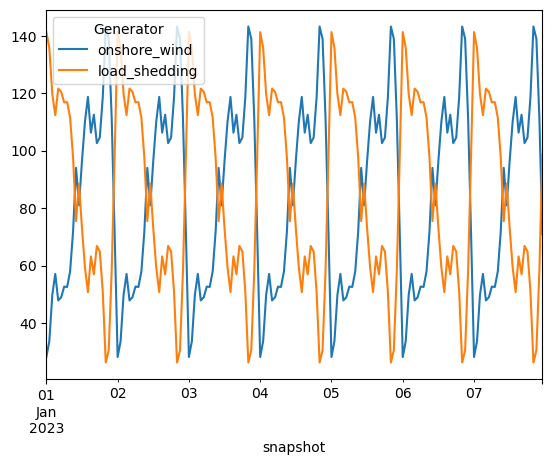

In [20]:
network.generators_t.p[: 24 * 7].plot()

In [21]:
network.links_t.p0.head()

Link,electrolyser
snapshot,
2023-01-01 00:00:00,169.491525
2023-01-01 01:00:00,169.491525
2023-01-01 02:00:00,169.491525
2023-01-01 03:00:00,169.491525
2023-01-01 04:00:00,169.491525


In [22]:
network.links_t.p1.head()

Link,electrolyser
snapshot,
2023-01-01 00:00:00,-100.0
2023-01-01 01:00:00,-100.0
2023-01-01 02:00:00,-100.0
2023-01-01 03:00:00,-100.0
2023-01-01 04:00:00,-100.0


In [23]:
network.loads_t.p.head()

Load,hydrogen_load
snapshot,
2023-01-01 00:00:00,100.0
2023-01-01 01:00:00,100.0
2023-01-01 02:00:00,100.0
2023-01-01 03:00:00,100.0
2023-01-01 04:00:00,100.0


Ending of check-point 1 - export network

In [24]:
# Export network
network.export_to_netcdf("../../results/network_d2_e1-1.nc")

INFO:pypsa.network.io:Exported network 'd2_h2_system_example_1'saved to '../../results/network_d2_e1-1.nc contains: links, generators, loads, buses


<xarray.Dataset> Size: 911kB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   links_i: 1, links_t_p0_i: 1,
                                   links_t_p1_i: 1, generators_i: 2,
                                   generators_t_p_max_pu_i: 1,
                                   generators_t_p_i: 2, loads_i: 1,
                                   loads_t_p_i: 1, buses_i: 2,
                                   buses_t_marginal_price_i: 2)
Coordinates:
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) object 0B 
  * links_i                       (links_i) object 8B 'electrolyser'
  * links_t_p0_i                  (links_t_p0_i) object 8B 'electrolyser'
  * links_t_p1_i                  (links_t_p1_i) object 8B 'electrolyser'
  * generators_i                  (generators_i) object 16B 'onshore_wind' 'l...
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 8B 'onshor...
  * generators_t_p_i              (generators_t_p_i) object 16B 'onshore_wind...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'hydrogen_load'
  * buses_i                       (buses_i) object 16B 'electricity' 'hydrogen'
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 16B 'elec...
Data variables: (12/31)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) object 0B 
    investment_periods_years      (investment_periods) object 0B 
    ...                            ...
    generators_t_p                (snapshots, generators_t_p_i) float64 140kB ...
    loads_bus                     (loads_i) object 8B 'hydrogen'
    loads_p_set                   (loads_i) float64 8B 100.0
    loads_t_p                     (snapshots, loads_t_p_i) float64 70kB 100.0...
    buses_carrier                 (buses_i) object 16B 'electricity' 'hydrogen'
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 140kB ...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           7509072242.728665
    network__objective_constant:  3510.8856999303816
    network_name:                 d2_h2_system_example_1
    network_objective:            7509072242.728665
    network_objective_constant:   3510.8856999303816
    network_pypsa_version:        0.35.2
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}

***
Check-point 2:

**Add a solar generator so that we will have two generators + one load-shedding generator in the system**

<img src="../../data/block diagrams/d2_e1-2.svg" width=500/>

In [25]:
# Import check-point 1 network
network = pypsa.Network("../../results/network_d2_e1-1.nc")

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'd2_h2_system_example_1' has buses, generators, links, loads


In [26]:
# Import an example of solar daily pattern
solar_pattern = pd.read_csv("../../data/weather data/example_solar_daily_pattern.csv")[
    "daily pattern"
]
# annual time-series availability of solar (just a simplified example)
solar_profile = pd.Series(list(solar_pattern) * 365, index=network.snapshots)

<Axes: xlabel='snapshot'>

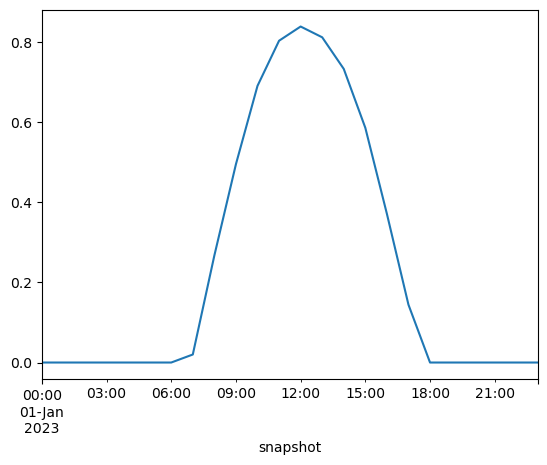

In [27]:
solar_profile.head(24).plot()

Add a solar generator at the electricity bus with a initial capacity of `50MW`, maximum capacity of `500MW`, and marginal cost of `0$/MWh` into the network? The name of the generator can be `solar`. 

In [28]:
network.add(
    class_name="Generator",
    name="solar",
    bus="electricity",
    carrier="electricity",
    p_nom_extendable=True,
    p_nom=50,
    p_nom_max=500,  # MW
    marginal_cost=0,  # $/MWh
    p_max_pu=solar_profile,
)

Index(['solar'], dtype='object')

In [29]:
network.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
onshore_wind,electricity,PQ,,100.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,500.000000
load_shedding,electricity,PQ,,0.0,0.0,True,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,141.304013
solar,electricity,PQ,,50.0,0.0,True,0.0,500.0,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.000000


Ending of check-point 2 - Solve network, analyse results and export network

In [30]:
# Solve network using cbc solver
network.optimize(pyomo=False, solver_name=solver)

Index(['electrolyser'], dtype='object', name='Link')


Index(['onshore_wind', 'load_shedding', 'solar'], dtype='object', name='Generator')
Index(['electricity', 'hydrogen'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - pyomo: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00, 101.18it/s]
INFO:linopy.io: Writing time: 0.65s


ERROR:   getOptionIndex: Option "pyomo" is unknown
Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-oxktkea3 has 87606 rows; 35045 cols; 144181 nonzeros
Coefficient ranges:
  Matrix  [2e-02, 1e+00]
  Cost    [1e+00, 1e+04]
  Bound   [4e+03, 4e+03]
  RHS     [1e+02, 5e+02]
Presolving model
8760 rows, 21536 cols, 21535 nonzeros  0s
0 rows, 730 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-87606); columns 0(-35045); nonzeros 0(-144181) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-oxktkea3
Model status        : Optimal
Objective value     :  4.7601256617e+09
P-D objective error :  1.1019055194e-14
HiGHS run time      :          0.16


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 35045 primals, 87606 duals
Objective: 4.76e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper were not assigned to the network.


('ok', 'optimal')

In [31]:
network.generators["p_nom_opt"]

Generator
onshore_wind     500.000000
load_shedding    141.304013
solar            500.000000
Name: p_nom_opt, dtype: float64

<Axes: xlabel='snapshot'>

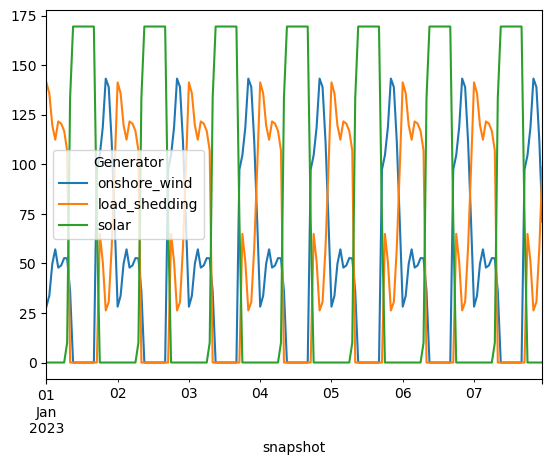

In [32]:
# Inspect the interaction of different power plants to supply loads
network.generators_t.p[: 24 * 7].plot()

<Axes: xlabel='snapshot'>

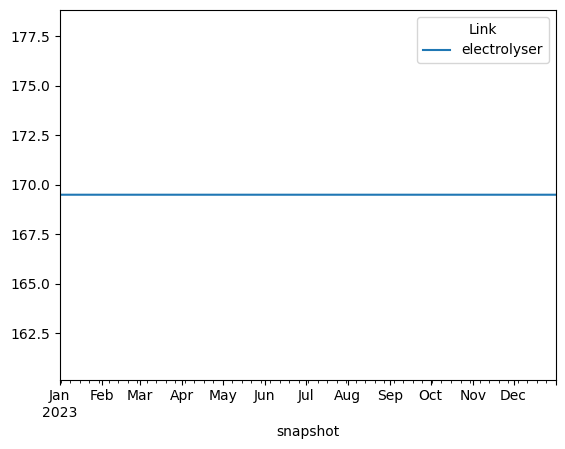

In [33]:
# Inspect the electrolysis conversion
network.links_t.p0.plot()

In [34]:
# Exporting check-point 2 network
network.export_to_netcdf("../../results/network_d2_e1-2.nc")

INFO:pypsa.network.io:Exported network 'd2_h2_system_example_1'saved to '../../results/network_d2_e1-2.nc contains: links, generators, loads, buses


<xarray.Dataset> Size: 1MB
Dimensions:                       (snapshots: 8760, investment_periods: 0,
                                   links_i: 1, links_t_p0_i: 1,
                                   links_t_p1_i: 1, generators_i: 3,
                                   generators_t_p_max_pu_i: 2,
                                   generators_t_p_i: 3, loads_i: 1,
                                   loads_t_p_i: 1, buses_i: 2,
                                   buses_t_marginal_price_i: 2)
Coordinates:
  * snapshots                     (snapshots) int64 70kB 0 1 2 ... 8758 8759
  * investment_periods            (investment_periods) object 0B 
  * links_i                       (links_i) object 8B 'electrolyser'
  * links_t_p0_i                  (links_t_p0_i) object 8B 'electrolyser'
  * links_t_p1_i                  (links_t_p1_i) object 8B 'electrolyser'
  * generators_i                  (generators_i) object 24B 'onshore_wind' .....
  * generators_t_p_max_pu_i       (generators_t_p_max_pu_i) object 16B 'onsho...
  * generators_t_p_i              (generators_t_p_i) object 24B 'onshore_wind...
  * loads_i                       (loads_i) object 8B 'hydrogen_load'
  * loads_t_p_i                   (loads_t_p_i) object 8B 'hydrogen_load'
  * buses_i                       (buses_i) object 16B 'electricity' 'hydrogen'
  * buses_t_marginal_price_i      (buses_t_marginal_price_i) object 16B 'elec...
Data variables: (12/31)
    snapshots_snapshot            (snapshots) datetime64[ns] 70kB 2023-01-01 ...
    snapshots_objective           (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_stores              (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    snapshots_generators          (snapshots) float64 70kB 1.0 1.0 ... 1.0 1.0
    investment_periods_objective  (investment_periods) float64 0B 
    investment_periods_years      (investment_periods) float64 0B 
    ...                            ...
    generators_t_p                (snapshots, generators_t_p_i) float64 210kB ...
    loads_bus                     (loads_i) object 8B 'hydrogen'
    loads_p_set                   (loads_i) float64 8B 100.0
    loads_t_p                     (snapshots, loads_t_p_i) float64 70kB 100.0...
    buses_carrier                 (buses_i) object 16B 'electricity' 'hydrogen'
    buses_t_marginal_price        (snapshots, buses_t_marginal_price_i) float64 140kB ...
Attributes:
    network__linearized_uc:       0
    network__multi_invest:        0
    network__objective:           4760125661.687716
    network__objective_constant:  3510.8856999303816
    network_name:                 d2_h2_system_example_1
    network_objective:            4760125661.687716
    network_objective_constant:   3510.8856999303816
    network_pypsa_version:        0.35.2
    network_srid:                 4326
    crs:                          {"_crs": "GEOGCRS[\"WGS 84\",ENSEMBLE[\"Wor...
    meta:                         {}